# Data Processing

In [7]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)

In [8]:
df_train = pd.read_csv("../data/yahoo/ydata-ymusic-rating-study-v1_0-train.txt", sep="\t", header=None)
df_train.columns = ["user_id", "item_id", "rating"]
df_train.head()

,user_id,item_id,rating
0,1,14,5
1,1,35,1
2,1,46,1
3,1,83,1
4,1,93,1


In [9]:
item_encoder = preprocessing.LabelEncoder().fit(df_train.item_id.values)
df_train.item_id = item_encoder.transform(df_train.item_id.values)

user_encoder = preprocessing.LabelEncoder().fit(df_train.user_id.values)
df_train.user_id = user_encoder.transform(df_train.user_id.values)

In [10]:
df_train.to_csv("../data/yahoo/ratings.csv", index=False)

# TRAIN PMF

In [11]:
from __future__ import print_function

import os
import pickle

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data

import matplotlib.pyplot as plt

import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [12]:
def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

In [59]:
batch_size = 100000
epoches = 1000
no_cuda = False
seed = 1
weight_decay = 0.1
embedding_feature_size = 100
ratio = 0.8
lr = 0.0001
momentum = 0.9

In [60]:
df = pd.read_csv("../data/yahoo/ratings.csv")
df.head(), df.count()

(   user_id  item_id  rating
 0        0       13       5
 1        0       34       1
 2        0       45       1
 3        0       82       1
 4        0       92       1,
 user_id    311704
 item_id    311704
 rating     311704
 dtype: int64)

In [61]:
data = df[["user_id", "item_id", "rating"]].values

# Normalize rewards to [-1, 1]
data[:,2] = 0.5*(data[:,2] - 3)

# Shuffle data
np.random.shuffle(data)

In [62]:
NUM_ITEMS = df.item_id.max() + 1
NUM_USERS = df.user_id.max() + 1

print(NUM_USERS, NUM_ITEMS)

15400 1000


In [63]:
# Split data
train_data = data[:int(ratio * data.shape[0])]
vali_data = data[int(ratio * data.shape[0]): int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio + (1 - ratio) / 2) * data.shape[0]) :]

In [64]:
no_cuda=False

# Get CUDA device if available
cuda = torch.cuda.is_available()
 
# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda and no_cuda else "cpu")
 
# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)
 
# Specify number of workers for cuda
kwargs = {"num_workers":1, "pin_memory":True} if cuda else {}
 
# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

In [65]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=no_cuda)
 
# Move model to CUDA if CUDA selected
if cuda and not no_cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction="sum")

# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Model moved to CUDA


In [66]:
# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row 0, item_id_nums: col 1 , ratings: val 2
        row = ele[:, 0]
        col = ele[:, 1]
        val = ele[:, 2]
 
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda and not no_cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.data
 
    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

In [67]:
# Training Model
count = 0
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print("parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}".format(ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):

    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)

    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())

    # Move validation data to CUDA
    if cuda and not no_cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long())

    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)

    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())

    # Calculate validation rmse loss
    if cuda and not no_cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_data[:, 2])
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_data[:, 2])

    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)

    print("Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}". \
            format(epoch, train_rmse, vali_rmse))

    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
        last_vali_rmse = vali_rmse
    

parameters are: train ratio:0.800000,batch_size:100000, epoches:1000, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(15400, 100)
  (item_embeddings): Embedding(1000, 100)
  (ub): Embedding(15400, 1)
  (ib): Embedding(1000, 1)
)
Training epoch: 1, training rmse: 0.801555, vali rmse:0.772685
Training epoch: 2, training rmse: 0.764267, vali rmse:0.740074
Training epoch: 3, training rmse: 0.728976, vali rmse:0.716206
Training epoch: 4, training rmse: 0.705188, vali rmse:0.696176
Training epoch: 5, training rmse: 0.687055, vali rmse:0.683745
Training epoch: 6, training rmse: 0.673468, vali rmse:0.672594
Training epoch: 7, training rmse: 0.660765, vali rmse:0.662412
Training epoch: 8, training rmse: 0.649608, vali rmse:0.654363
Training epoch: 9, training rmse: 0.640551, vali rmse:0.647790
Training epoch: 10, training rmse: 0.632214, vali rmse:0.641195
Training epoch: 11, training rmse: 0.624408, vali rmse:0.634649
Training epoch: 12, training rmse: 0.617583, vali rmse:0.629949
Tr

In [68]:
# Testing Model

# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long())
 
# Get test predictions
preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 2])
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 2])
print("Test rmse: {:f}".format(test_rmse))

Test rmse: 0.585930


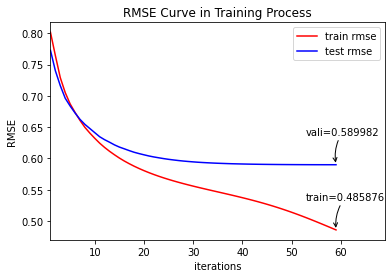

In [69]:
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color="r", label="train rmse")
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color="b", label="test rmse")
plt.legend()
plt.annotate(r"train=%f" % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.annotate(r"vali=%f" % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel("iterations")
plt.ylabel("RMSE")
plt.title("RMSE Curve in Training Process")
plt.show()

In [70]:
(embedding_feature_size, ratio, batch_size, len(train_rmse_list), weight_decay, lr)

(100, 0.8, 100000, 59, 0.1, 0.0001)

In [71]:
# Save model
path_to_trained_pmf = "../model/pmf/yahoo_emb_{:d}_ratio_{:f}_bs_{:d}_e_{:d}_r{:f}_wd_{:f}_lr_{:f}_trained_pmf.pt".format(embedding_feature_size, ratio, batch_size, len(train_rmse_list), test_rmse, weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)

In [72]:
idx =  -1
(model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] + 1) / 2, (data[idx][2] + 1) / 2

(tensor(0.3946), 0.5)

In [73]:
idx =  -2
(model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] + 1) / 2, (data[idx][2] + 1) / 2

(tensor(0.8325), 0.5)

In [74]:
idx =  -3
(model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] + 1) / 2, (data[idx][2] + 1) / 2

(tensor(0.7774), 0.5)

# Data Processing

In [86]:
import pandas as pd
import pickle
import numpy as np

In [76]:
import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)

In [77]:
df = pd.read_csv("../data/yahoo/ratings.csv")
df.head(), df.count()

(   user_id  item_id  rating
 0        0       13       5
 1        0       34       1
 2        0       45       1
 3        0       82       1
 4        0       92       1,
 user_id    311704
 item_id    311704
 rating     311704
 dtype: int64)

In [79]:
users_dict = {user: [] for user in set(df["user_id"])}

ratings_df_gen = df.iterrows()
users_dict_positive_items = {
    user: [] for user in set(df["user_id"])
}
for data in ratings_df_gen:
    users_dict[data[1]["user_id"]].append(
        (data[1]["item_id"], data[1]["rating"])
    )
    if data[1]["rating"] >= 4:
        users_dict_positive_items[data[1]["user_id"]].append(
            (data[1]["item_id"], data[1]["rating"])
        )
users_history_lens = [
    len(users_dict_positive_items[u])
    for u in set(df["user_id"])
]

users_num = max(df["user_id"]) + 1
items_num = max(df["item_id"]) + 1

print(users_num, items_num)

15400 1000


In [80]:
train_users_num = int(users_num * 0.8)
train_users_dict = {k: users_dict.get(k) for k in range(0, train_users_num - 1)}
train_users_history_lens = users_history_lens[:train_users_num]

# Evaluating setting
eval_users_num = int(users_num * 0.2)
eval_users_dict = {
    k: users_dict[k] for k in range(users_num - eval_users_num, users_num)
}
eval_users_history_lens = users_history_lens[-eval_users_num:]


In [81]:
# Save processed data
with open("../data/yahoo/train_users_dict.pkl", "wb") as file:
    pickle.dump(train_users_dict, file)

with open("../data/yahoo/train_users_history_lens.pkl", "wb") as file:
    pickle.dump(train_users_history_lens, file)

with open("../data/yahoo/eval_users_dict.pkl", "wb") as file:
    pickle.dump(eval_users_dict, file)

with open("../data/yahoo/eval_users_history_lens.pkl", "wb") as file:
    pickle.dump(eval_users_history_lens, file)

with open("../data/yahoo/users_history_lens.pkl", "wb") as file:
    pickle.dump(users_history_lens, file)


In [82]:
z = np.random.geometric(p=0.35, size=items_num)
w = z%10 
w = [i if i > 0 else 10 for i in w]

In [83]:
px.histogram(w)

In [84]:
item_group = {i: w[i] for i in range(items_num)}

In [85]:
with open("../data/yahoo/item_groups.pkl", "wb") as file:
    pickle.dump(item_group, file)

# EDA

In [1]:
import os
import json
import pickle

import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)


import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [2]:
data_version = "yahoo"
dataset_path = "../data/{}_output_path.json".format(data_version)

with open(dataset_path) as json_file:
    _dataset_path = json.load(json_file)

dataset = {}
with open(os.path.join("..", _dataset_path["train_users_dict"]), "rb") as pkl_file:
    dataset["train_users_dict"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["train_users_history_lens"]), "rb") as pkl_file:
    dataset["train_users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["eval_users_dict"]), "rb") as pkl_file:
    dataset["eval_users_dict"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["eval_users_history_lens"]), "rb") as pkl_file:
    dataset["eval_users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["users_history_lens"]), "rb") as pkl_file:
    dataset["users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["item_groups"]), "rb") as pkl_file:
    dataset["item_groups"] = pickle.load(pkl_file)

# items_df = pd.read_csv(os.path.join("..", _dataset_path["items_df"]))
# items_metadata_df = pd.read_csv(os.path.join("..", _dataset_path["items_metadata"]))
# users_df = pd.read_csv(os.path.join("..",_dataset_path["users_df"]))
ratings_df = pd.read_csv(os.path.join("..",_dataset_path["ratings_df"]))


# items_df = items_df.set_index("item_id")
# items_metadata_df = items_metadata_df.set_index("item_id")
# users_df = users_df.set_index("user_id")

In [11]:
items_df = pd.DataFrame(ratings_df.item_id.sort_values().unique(), columns = ['item_id'])
items_df

,item_id
0,0
1,1
2,2
3,3
4,4
...,...
995,995
996,996
997,997
998,998


In [7]:
def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax
    
def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    
    return ax

In [8]:
def single_list_similarity(predicted, feature_df):
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    # #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)
    upper_right

    # #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

In [9]:
import torch

In [12]:
reward_model = PMF(15400, 1000, 100).to("cuda")
reward_model.load_state_dict(
    torch.load(
        "../model/pmf/yahoo_emb_100_ratio_0.800000_bs_100000_e_59_r0.585930_wd_0.100000_lr_0.000100_trained_pmf.pt",
        map_location=torch.device("cuda"),
    )
)

user_embeddings = reward_model.user_embeddings.weight.data
item_embeddings = reward_model.item_embeddings.weight.data

# users_pmf_emb = pd.DataFrame(user_embeddings[users_df.index.values].cpu().numpy().tolist())
item_pmf_emb = pd.DataFrame(item_embeddings[items_df.index.values].cpu().numpy().tolist())

In [7]:
# # The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# # out some marginal improvements. NB: This takes almost an hour!
# tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

# embs = tsne.fit_transform(item_pmf_emb.values)
# # Add to dataframe for convenience
# items_df['x'] = embs[:, 0]
# items_df['y'] = embs[:, 1]

# FS = (10, 8)
# fig, ax = plt.subplots(figsize=FS)
# fig.patch.set_facecolor("white")
# # Make points translucent so we can visually identify regions with a high density of overlapping points
# ax.scatter(items_df.x, items_df.y, alpha=.1)

In [14]:
users = ratings_df[ratings_df["rating"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, item_pmf_emb))

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib

In [15]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")

In [7]:
bert = SentenceTransformer("all-MiniLM-L12-v1") # bert-base-nli-mean-tokens / all-MiniLM-L6-v2
sentence_embeddings = bert.encode(items_df["item_name"].tolist())
sentence_embeddings = pd.DataFrame(sentence_embeddings.tolist())
sentence_embeddings.shape

(20053, 384)

In [17]:
sentence_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.015144,-0.071096,-0.052696,0.006727,-0.168630,-0.002563,0.012260,-0.037356,-0.001255,-0.041857,...,0.038299,-0.070339,0.026429,-0.004698,0.037683,0.043657,-0.098955,0.074243,-0.094287,-0.062926
1,-0.009170,0.034275,0.000880,0.070700,-0.100277,0.034362,0.062539,-0.005892,0.061363,0.019352,...,-0.084614,-0.057344,-0.014082,-0.101240,0.046607,0.015310,0.002573,0.005158,0.043661,0.027962
2,-0.006024,0.025040,-0.051516,0.052450,-0.039815,-0.048768,0.070334,0.013523,0.060356,-0.007427,...,-0.042122,0.002577,-0.002215,0.005882,-0.005580,-0.051644,-0.085165,0.054586,0.007482,-0.038885
3,0.038174,0.067576,-0.003651,0.083262,-0.058924,0.002755,0.044433,-0.003987,-0.026585,0.021955,...,-0.024589,-0.022719,-0.044386,-0.085968,0.076934,-0.008524,0.006511,-0.007896,0.018868,-0.023109
4,0.040565,-0.071196,-0.026461,0.072117,0.017087,0.061714,-0.007144,0.078634,-0.057483,-0.028783,...,-0.046940,0.009286,0.034223,-0.076776,-0.006618,-0.044619,0.018366,0.045473,0.024815,-0.003015


In [8]:
sentence_embeddings.to_csv("../data/yelp/sentence_embeddings.csv", index=False)

In [27]:
sentence_embeddings.loc[[0, 1]]

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.015144,-0.071096,-0.052696,0.006727,-0.168630,-0.002563,0.012260,-0.037356,-0.001255,-0.041857,...,0.038299,-0.070339,0.026429,-0.004698,0.037683,0.043657,-0.098955,0.074243,-0.094287,-0.062926
1,-0.009170,0.034275,0.000880,0.070700,-0.100277,0.034362,0.062539,-0.005892,0.061363,0.019352,...,-0.084614,-0.057344,-0.014082,-0.101240,0.046607,0.015310,0.002573,0.005158,0.043661,0.027962


In [21]:
pd.read_csv("../data/yelp_toronto/setence_embeddings.csv").head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,0,-0.015144,-0.071096,-0.052696,0.006727,-0.168630,-0.002563,0.012260,-0.037356,-0.001255,...,0.038299,-0.070339,0.026429,-0.004698,0.037683,0.043657,-0.098955,0.074243,-0.094287,-0.062926
1,1,-0.009170,0.034275,0.000880,0.070700,-0.100277,0.034362,0.062539,-0.005892,0.061363,...,-0.084614,-0.057344,-0.014082,-0.101240,0.046607,0.015310,0.002573,0.005158,0.043661,0.027962
2,2,-0.006024,0.025040,-0.051516,0.052450,-0.039815,-0.048768,0.070334,0.013523,0.060356,...,-0.042122,0.002577,-0.002215,0.005882,-0.005580,-0.051644,-0.085165,0.054586,0.007482,-0.038885
3,3,0.038174,0.067576,-0.003651,0.083262,-0.058924,0.002755,0.044433,-0.003987,-0.026585,...,-0.024589,-0.022719,-0.044386,-0.085968,0.076934,-0.008524,0.006511,-0.007896,0.018868,-0.023109
4,4,0.040565,-0.071196,-0.026461,0.072117,0.017087,0.061714,-0.007144,0.078634,-0.057483,...,-0.046940,0.009286,0.034223,-0.076776,-0.006618,-0.044619,0.018366,0.045473,0.024815,-0.003015


In [18]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(sentence_embeddings.values)
# Add to dataframe for convenience
items_df['x'] = embs[:, 0]
items_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(items_df.x, items_df.y, alpha=.1)

KeyboardInterrupt: 

In [13]:
users = ratings_df[ratings_df["stars"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, sentence_embeddings))

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/home/luana/data/miniconda3/envs/rsrl/lib

In [14]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")